# **MINI-PROJECT-3: House Price Estimation**

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
%cd "/content/drive/My Drive/P3_HousePrice/P3_CodeBase"

# install import-ipynb for importing helper modules
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as gplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P3_HousePrice/P3_CodeBase


In [95]:
data_path = "/content/drive/My Drive/P3_HousePrice/P3_CodeBase/data/"
dnn_path = "/content/drive/My Drive/P3_HousePrice/P3_CodeBase/dnn/"
image_path="/content/drive/My Drive/P3_HousePrice/P3_CodeBase/data/Preprocessed_Images/"

## **Data Preprocessing**

### **Textual PreProcessing**

In [96]:
import pandas as pd
import io
import os
import requests
import numpy as np
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = os.path.join(data_path, "HousesInfo.txt")
df = pd.read_csv(filepath, names=['Bedrooms','Bathrooms','Area','Zipcode','Price'], delim_whitespace=True)
df

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


#### **Check Shape and for Null values**

In [97]:
print(df.shape)
print(df.isnull().sum())

(535, 5)
Bedrooms     0
Bathrooms    0
Area         0
Zipcode      0
Price        0
dtype: int64


#### **Adding House no column to keep track of house numbers**

In [98]:
df.insert(0, 'House#', range(1, len(df)+1))

#### **Removing Outliers**

In [99]:
df_filtered = df.query('100000 < Price < 900000')
df_filtered.shape

(405, 6)

#### **Removing rows with low frequency zipcodes**

In [100]:
# Zipcode Processing
df_zipcode = pd.DataFrame(df_filtered['Zipcode'].value_counts()) # to get frequency count of various zipcodes
zipcode_outliers=[]
# adding zipcodes with 1 or 2 houses to zipcode outliers
for row_index,row in df_zipcode.iterrows():
  if row.Zipcode in [1,2]:
    zipcode_outliers.append(row_index)
zipcode_outliers

[81418,
 62025,
 60016,
 92253,
 92692,
 60046,
 62088,
 93314,
 85262,
 81521,
 62249,
 85331,
 94565,
 94568,
 62034,
 92543,
 36372,
 93105,
 91915]

In [101]:
# removing rows having low frequency zipcodes
print(f"Dataframe shape before{df_filtered.shape}")
df_filtered = df_filtered[~df_filtered['Zipcode'].isin(zipcode_outliers)].copy()
print(f"DataFrame shape after removing zipcode outliers {df_filtered.shape}")

Dataframe shape before(405, 6)
DataFrame shape after removing zipcode outliers (381, 6)


#### **Encoding and Normalization**

In [102]:
for col in ['Bedrooms','Bathrooms','Zipcode']:
  dataprep.encode_text_dummy(df_filtered, col)

dataprep.encode_numeric_range(df_filtered,'Area')


### **Image Preprocessing**

In [103]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image

#### **Preparing array of all image urls**

In [104]:
img = []
frontal_images, bedroom_images, bathroom_images, kitchen_images = [], [], [], []
for number in df['House#']:
  for imgtype in ["_frontal.jpg", "_bedroom.jpg", "_bathroom.jpg", "_kitchen.jpg"]:
    for path in glob.glob("/content/drive/My Drive/P3_HousePrice/P3_CodeBase/data/img/" + str(number) + imgtype):
      if os.path.isfile(path):
        if imgtype == "_frontal.jpg":
          frontal_images.append(path)
        elif imgtype == "_bedroom.jpg":
          bedroom_images.append(path)
        elif imgtype == "_bathroom.jpg":
          bathroom_images.append(path)
        elif imgtype == "_kitchen.jpg":
          kitchen_images.append(path)
        else:
          None

img = pd.DataFrame(img , columns=['frontal_img','bedroom_img', 'bathroom_img', 'kitchen_img'])
          
img['frontal_img'] = frontal_images
img['bedroom_img'] = bedroom_images
img['bathroom_img']= bathroom_images
img['kitchen_img'] = kitchen_images

img.insert(0, 'House#', df['House#'])


img[0:5]

,House#,frontal_img,bedroom_img,bathroom_img,kitchen_img
0,1,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
1,2,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
2,3,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
3,4,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
4,5,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...


#### **Removing Outliers**

In [105]:
# retaining index values having matching textual values
df_textual_indexes = set(df_filtered.index.values)
df_img_indexes = set(img.index.values)
unmatched_indexes = list(df_img_indexes - df_textual_indexes)
img.drop(unmatched_indexes, inplace=True)

img

,House#,frontal_img,bedroom_img,bathroom_img,kitchen_img
0,1,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
2,3,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
10,11,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
12,13,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
13,14,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
...,...,...,...,...,...
530,531,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
531,532,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
532,533,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...
533,534,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...,/content/drive/My Drive/P3_HousePrice/P3_CodeB...


In [106]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
                  
            images_output.append(outputImage)
                  
print("Successfully processed images")        

Successfully processed images


In [107]:
images_output = np.array(images_output,dtype=float)
images_output = images_output/255;
img_array = np.asarray(images_output)
img_array.shape

(381, 128, 128, 3)

In [108]:
df_filtered = df_filtered.astype('float32');

df_filtered.drop("House#", axis =1, inplace=True)
x, y = dataprep.to_xy(df_filtered, 'Price')

## **Train and Test Split**

In [109]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=25)
img_train, img_test = train_test_split(img_array, test_size=0.30, random_state=25)

In [110]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape, img_train.shape, img_test.shape

((266, 42), (115, 42), (266,), (115,), (266, 128, 128, 3), (115, 128, 128, 3))

## **Saving Preprocessed Datasets** -To be removed 

In [111]:
img_write = os.path.join(data_path,"P3_Zipcode_ImageDataset.csv")
text_write = os.path.join(data_path,"P3_Zipcode_TextDataset.csv")

img.to_csv(img_write,index=False)
df_filtered.to_csv(text_write,index=False)

print("Successfully saved preprocessed dataset")

Successfully saved preprocessed dataset


## **Model Creation and Evaluation**

### **CASE 1: Without Transfer Learning**

In [151]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate

# Input Channel for Images - CNN
visible1 = Input(shape=(128,128,3))
conv11 = Conv2D(32, kernel_size=4, activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(16, kernel_size=4, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
cnn_flat = Flatten()(pool12)


# Input channel for Textual Info
visible2 = Input(shape=(x_train.shape[1],))
hidden21 = Dense(128, activation='relu')(visible2)
hidden22 = Dense(64, activation='relu')(hidden21)
nn_hidden = Dense(32, activation='relu')(hidden22)
#nn_hidden = Dense(1, activation='relu')(hidden23)


# merge input models
merge = concatenate([cnn_flat, nn_hidden])


# interpretation model
hidden1 = Dense(50, activation='relu')(merge)
hidden2 = Dense(20, activation='relu')(hidden1)
output = Dense(1)(hidden2)

print("Added layers ....")

Added layers ....


#### **Model Training**

In [152]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

bestModelPath=os.path.join(dnn_path,"P3_Zipcode_WithoutTF.hdf5")
checkpoint = ModelCheckpoint(filepath=bestModelPath, verbose=0, save_best_only=True)
#custom_sgd = optimizers.SGD(lr=0.01 , clipvalue=1)
for i in range(5):
  print(f"ITERATION {i+1} ------------------------->")
  model = Model(inputs=[visible1, visible2], outputs=output)
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
  model.fit([img_train,x_train], y_train, validation_data=([img_test, x_test], y_test),callbacks=[monitor,checkpoint],verbose=2,epochs=1000,batch_size=12)



ITERATION 1 ------------------------->
Epoch 1/1000
23/23 - 1s - loss: 285014556672.0000 - val_loss: 282195951616.0000
Epoch 2/1000
23/23 - 0s - loss: 269684506624.0000 - val_loss: 231435517952.0000
Epoch 3/1000
23/23 - 0s - loss: 151734861824.0000 - val_loss: 45509345280.0000
Epoch 4/1000
23/23 - 0s - loss: 47765213184.0000 - val_loss: 42932469760.0000
Epoch 5/1000
23/23 - 0s - loss: 48912441344.0000 - val_loss: 44116914176.0000
Epoch 6/1000
23/23 - 0s - loss: 47753666560.0000 - val_loss: 43205431296.0000
Epoch 7/1000
23/23 - 0s - loss: 46424387584.0000 - val_loss: 43094593536.0000
Epoch 8/1000
23/23 - 0s - loss: 47227441152.0000 - val_loss: 42646441984.0000
Epoch 9/1000
23/23 - 0s - loss: 46058016768.0000 - val_loss: 43163377664.0000
Epoch 10/1000
23/23 - 0s - loss: 46067802112.0000 - val_loss: 42120761344.0000
Epoch 11/1000
23/23 - 0s - loss: 45234708480.0000 - val_loss: 41022083072.0000
Epoch 12/1000
23/23 - 0s - loss: 43723124736.0000 - val_loss: 39816122368.0000
Epoch 13/1000
23/

#### **Model Testing and Performance Evaluation**

In [153]:
model.load_weights(bestModelPath)
pred=model.predict([img_test,x_test])
#shapes of prediction and test datasets
pred = pred.flatten()
print(pred.shape, y_test.shape)
print()
print("----------Ground truth values-------------")
print(y_test[0:5])
print("----------Predicted values-----------------")
print(pred[0:5])

(115,) (115,)

----------Ground truth values-------------
[538000. 395000. 695000. 699999. 549900.]
----------Predicted values-----------------
[669113.4  447197.72 695368.94 638747.5  444168.28]


-------- Performance Evalutation for  Zipcode Feature Tuning without Transfer Learning  --------

RMSE         : 105877.2
MSE          : 11209982000.0
R2 score     : 0.7442995002913024
-------- Regression Chart --------


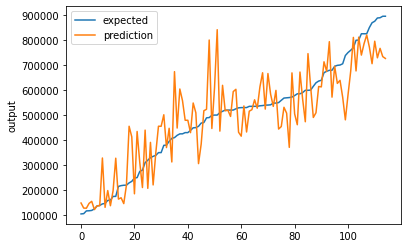

In [154]:
gplot.regression_performance_metrics(y_test,pred,"Zipcode Feature Tuning without Transfer Learning")
gplot.chart_regression(pred.flatten(),y_test)

Model: "functional_103"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 125, 125, 32) 1568        input_33[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 62, 62, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 42)]         0                                            
_____________________________________________________________________________________

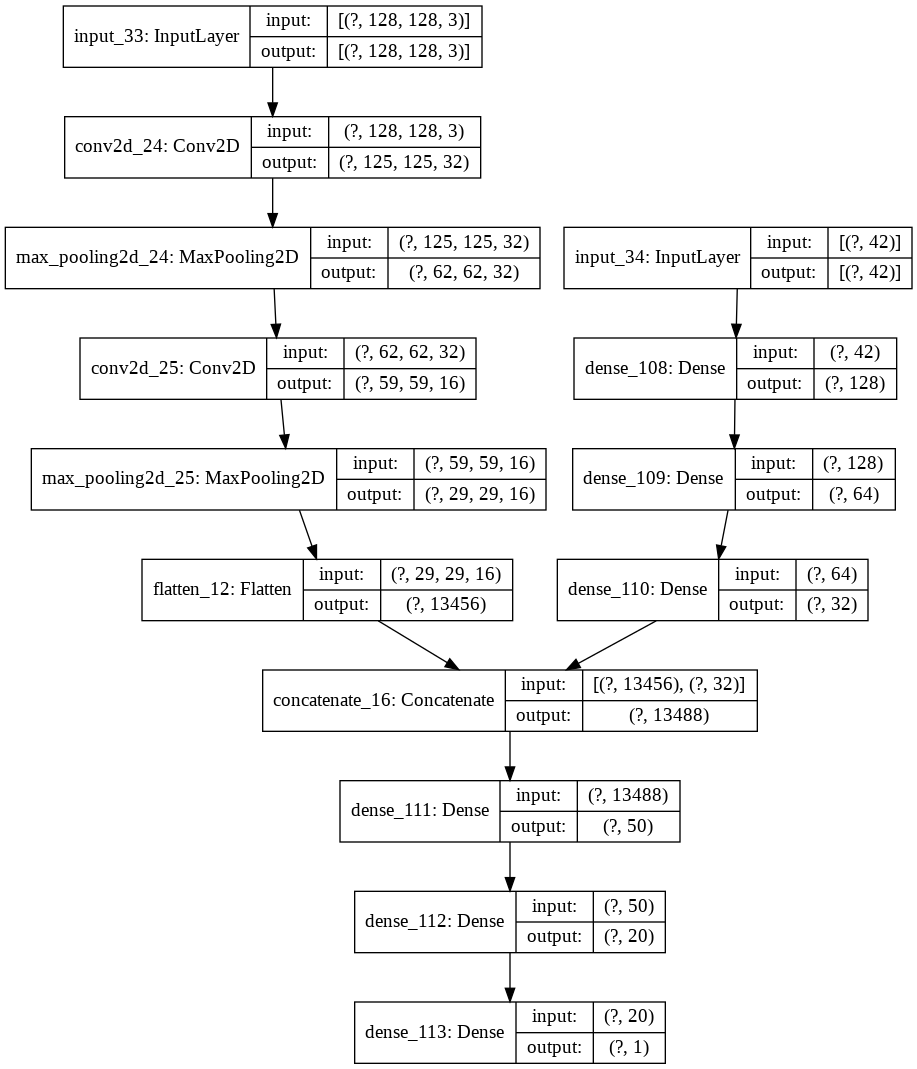

In [155]:

# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file = dnn_path + 'P3_Zip_WithoutTF.png', show_shapes=True)

### **CASE 2: MobileNet**

In [160]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in mobilenet_model.layers:
    layer.trainable=False

mn_out = mobilenet_model.output

ga_layer=GlobalAveragePooling2D()(mn_out)
hidden11=Dense(128,activation='relu')(ga_layer)
hidden12=Dense(64,activation='relu')(hidden11)
mbnet_concat=Dense(32,activation='relu')(hidden12)

# Input channel for Textual Info
nn_input = Input(shape=(x_train.shape[1],))
hidden21 = Dense(128, activation='relu')(nn_input)
hidden22 = Dense(64, activation='relu')(hidden21)
nn_concat = Dense(32, activation='relu')(hidden22)

# merge input models
merge = concatenate([mbnet_concat, nn_concat])


# interpretation model
hidden1 = Dense(50, activation='relu')(merge)
hidden2 = Dense(20, activation='relu')(hidden1)
output = Dense(1)(hidden2)

print("Added MobileNet layers....")

Added MobileNet layers....


#### **Model Training**

In [161]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

bestModelPath=os.path.join(dnn_path,"P3_Zipcode_MobileNet.hdf5")
checkpoint = ModelCheckpoint(filepath=bestModelPath, verbose=0, save_best_only=True)
#custom_sgd = optimizers.SGD(lr=0.001 , clipvalue=1)
for i in range(5):
  print(f"ITERATION {i+1} ------------------------->")
  model = Model(inputs=[mobilenet_model.input, nn_input], outputs=output)
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
  model.fit([img_train,x_train], y_train, validation_data=([img_test, x_test], y_test),callbacks=[monitor,checkpoint],verbose=2,epochs=1000,batch_size=12)


ITERATION 1 ------------------------->
Epoch 1/1000
23/23 - 2s - loss: 285347250176.0000 - val_loss: 284453175296.0000
Epoch 2/1000
23/23 - 1s - loss: 284503834624.0000 - val_loss: 281812434944.0000
Epoch 3/1000
23/23 - 1s - loss: 275992444928.0000 - val_loss: 260642373632.0000
Epoch 4/1000
23/23 - 1s - loss: 224514949120.0000 - val_loss: 161278640128.0000
Epoch 5/1000
23/23 - 1s - loss: 88539111424.0000 - val_loss: 46771003392.0000
Epoch 6/1000
23/23 - 1s - loss: 52537729024.0000 - val_loss: 45906870272.0000
Epoch 7/1000
23/23 - 1s - loss: 46805254144.0000 - val_loss: 44607062016.0000
Epoch 8/1000
23/23 - 1s - loss: 45444419584.0000 - val_loss: 43949985792.0000
Epoch 9/1000
23/23 - 1s - loss: 44694200320.0000 - val_loss: 43406667776.0000
Epoch 10/1000
23/23 - 1s - loss: 44037939200.0000 - val_loss: 42760974336.0000
Epoch 11/1000
23/23 - 1s - loss: 43554553856.0000 - val_loss: 42009104384.0000
Epoch 12/1000
23/23 - 1s - loss: 41798942720.0000 - val_loss: 40714391552.0000
Epoch 13/1000


#### **MobileNet Model Testing and Performance Evaluation**

In [158]:
model.load_weights(bestModelPath)
pred=model.predict([img_test,x_test])
#shapes of prediction and test datasets
pred = pred.flatten()
print(pred.shape, y_test.shape)
print()
print("----------Ground truth values-------------")
print(y_test[0:5])
print("----------Predicted values-----------------")
print(pred[0:5])

(115,) (115,)

----------Ground truth values-------------
[538000. 395000. 695000. 699999. 549900.]
----------Predicted values-----------------
[679285.4  428027.   683650.06 666545.9  507636.94]


-------- Performance Evalutation for  Zipcode Feature Tuning with MobileNet  --------

RMSE         : 106825.0
MSE          : 11411580000.0
R2 score     : 0.7397009775305776
-------- Regression Chart --------


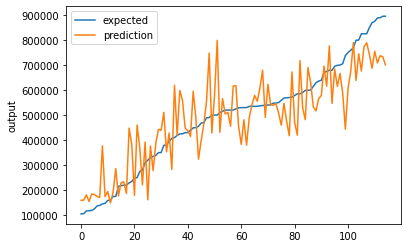

In [159]:
from sklearn import metrics
gplot.regression_performance_metrics(y_test,pred,"Zipcode Feature Tuning with MobileNet")
gplot.chart_regression(pred.flatten(),y_test)

In [135]:

# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file = dnn_path + 'P3_Zip_MobileNet.png', show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.